# DM-44022: analyze wfs grid for S/N implementation

Show the wfs grid results for different bands. I run the same slurm file as for `wfs_grid4`, but set a different filter (`u,g,r,i,z,y` explicitly), and use the latest cvmfs   `2024_20`:

Based on  `/sdf/group/rubin/shared/scichris/DM-43524_grid/runSlurm-wfs_test.sl`

make appropriate slurm files :



In [2]:
from lsst.ts.wep.utils import readConfigYaml
import lsst.daf.butler as dafButler
import os
import astropy.units as u
import numpy as np 
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml


In [1]:
def get_slurm_content(band,path_cwd, weekly="w_2024_21", sim = 6):
    slurm_log = f'wfs_grid_slurm_log{sim}{band}.sl'
    imsim_log = f'wfs_grid_imsim_log{sim}{band}.txt'
    path_slurm_log = os.path.join(path_cwd, slurm_log)
    path_imsim_log = os.path.join(path_cwd, imsim_log)
    
    path_output = os.path.join(path_cwd,f'wfs_grid{sim}{band}/')
    content = ['#!/bin/bash -l \n',
    '#SBATCH --partition milano \n',
    '#SBATCH --account rubin:developers \n',
    '#SBATCH --nodes 1 \n',
    '#SBATCH --mem=50G \n',
    '#SBATCH --cpus-per-task=80 \n',
    '#SBATCH -t 200:00:00 \n',
    f'#SBATCH --job-name w{sim}{band} \n',
    f'#SBATCH --output={path_slurm_log} \n',
    'echo "starting at `date` on `hostname`\n"' ,
    'pwd \n',


    f'source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/{weekly}/loadLSST-ext.bash \n',
    'setup lsst_distrib -t w_latest \n',
    
    'export IMSIM_HOME=/sdf/home/s/scichris/link_to_scichris/WORK/imsim_home \n',
    'export RUBIN_SIM_DATA_DIR=$IMSIM_HOME/rubin_sim_data \n',
    'export SIMS_SED_LIBRARY_DIR=$IMSIM_HOME/rubin_sim_data/sims_sed_library \n',
    'setup -k -r $IMSIM_HOME/imSim \n',
    'setup -k -r $IMSIM_HOME/skyCatalogs \n',
    'source  /sdf/data/rubin/user/scichris/WORK/aos_packages/setup_aos.sh  \n',
    
    f'python /sdf/data/rubin/user/scichris/WORK/aos_packages/ts_imsim/bin.src/img_closed_loop.py \
    --num_proc 50 --log_level 10 \
    --iter_num 5 --inst lsst  --imsim_log_file {path_imsim_log} \
    --output {path_output} \
    --sky_file /sdf/group/rubin/shared/scichris/DM-43524_grid/lsstCam_grid_random2.txt  --clobber \
    --pipeline_file /sdf/group/rubin/shared/scichris/DM-43524_grid/lsstPipelineCustomDoVar.yaml \
    --filter_type {band} \n',
    
    'echo "ended at `date` on `hostname`" \n']
    return content

The pipeline yaml file contains

    # This yaml file is used to define the tasks and configuration of
    # a Gen 3 pipeline used for testing in ts_wep.
    description: wep basic processing test pipeline
    # Here we specify the corresponding instrument for the data we
    # will be using.
    instrument: lsst.obs.lsst.LsstCam
    # Then we can specify each task in our pipeline by a name
    # and then specify the class name corresponding to that task
    tasks:
      isr:
        class: lsst.ip.isr.isrTask.IsrTask
        # Below we specify the configuration settings we want to use
        # when running the task in this pipeline. Since our data doesn't
        # include bias or flats we only want to use doApplyGains and
        # doOverscan in our isr task.
        config:
          connections.outputExposure: 'postISRCCD'
          doBias: False
          doVariance: True
          doLinearize: False
          doCrosstalk: False
          doDefect: False
          doNanMasking: False
          doInterpolate: False
          doBrighterFatter: False
          doDark: False
          doFlat: False
          doApplyGains: True
          doFringe: False
          doOverscan: True
          python: OverscanCorrectionTask.ConfigClass.fitType = 'MEDIAN'
      generateDonutCatalogWcsTask:
        class: lsst.ts.wep.task.generateDonutCatalogWcsTask.GenerateDonutCatalogWcsTask
        config:
          donutSelector.useCustomMagLimit: True
      cutOutDonutsCwfsTask:
        class: lsst.ts.wep.task.cutOutDonutsCwfsTask.CutOutDonutsCwfsTask
      calcZernikesTask:
        class: lsst.ts.wep.task.calcZernikesTask.CalcZernikesTask
        config:
          python: |
            from lsst.ts.wep.task import EstimateZernikesTieTask, EstimateZernikesDanishTask
            config.estimateZernikes.retarget(EstimateZernikesTieTask)

In [ ]:
def write_to_file(out_file, content):
    with open(out_file, "w") as output:
        for line in content:
            output.write(line)
path_cwd = '/sdf/group/rubin/shared/scichris/DM-43524_grid/'
for band in 'ugrizy': 
    content = get_slurm_content(band, path_cwd)
    slurm_file_path = os.path.join(path_cwd, f'runSlurm-wfs_test_{band}.sl')
    print(f'Saved as {slurm_file_path}')
    write_to_file(slurm_file_path, content)

Check the queue:

    squeue -u scichris
    sbatch /sdf/group/rubin/shared/scichris/DM-43524_grid/runSlurm-wfs_test_u.sl


Check the progress:

    more /sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid_slurm_log5u.sl 
    more /sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid_imsim_log5u.txt



Note:  this   (`wfs_grid5_ugriz`)  was using:
* `imSim` :  `v2.0.0`, the latest commit `7237452fdce9` from March 18th,
* `skyCatalogs`: ` v1.6.0rc2`  with `ce81bb8` from Aug 14th
* `Galsim`: `v2.5.1`  commit `ea0f82baaa` from Nov 7th


Updated (for `wfs_grid6_ugriz` ):  

* `imSim`: `v2.0.0`, latest commit `d580f71f` from May 23
* `skyCatalogs`: branch `main`, tag `v1.7.0rc4`, commit `e6b60f3d26` from May 16
* `Galsim` : `v2.5.2`, commit `df8a639d5` from May 9th



In [ ]:


entroThresh=3.5
# reading 
# https://github.com/lsst-ts/ts_wep/blob/develop/policy/magLimitStar.yaml 
magPolicyDefaults = readConfigYaml("policy:magLimitStar.yaml")
filter = exposure_extra.info.getFilter()
defaultFilterKey = f"filter{filter.bandLabel.upper()}"
magMax = magPolicyDefaults[defaultFilterKey]["high"]
magMin = magPolicyDefaults[defaultFilterKey]["low"]

In [10]:
# Code to calculate SN:

from scipy.ndimage import binary_dilation


import scipy
import astropy.units as u
def calculate_entropy(stamp):
    d = stamp.stamp_im.image.array
    # these follow code from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/donutImageCheck.py
    array1d = d.flatten()
    #entroThres = 3.5
    numOfBins = 256
    hist, edges = np.histogram(array1d, bins=numOfBins)
    
    # Square the distribution to magnify the difference in entropy
    imgEntropy = scipy.stats.entropy(hist**2)
    
    return imgEntropy, hist, edges, 

def calculateSN(stamp,sourceErosionIter=1, bkgDilationIter=10):
        """
        Calculate signal-to-noise ratio.

        Parameters
        ----------
        stamp : lsst.ts.wep.task.donutStamp
            A stamp containing donut image.


        Returns
        -------
        dict
             A dictionary of calculated quantities:
            'SN': the signal to noise ratio
            'signal': the calculated signal
            'noise': the calculated noise
        """

        #stamp.makeMask(instConfigFile, self.opticalModel)
        stamp_mask = stamp.stamp_im.mask.array
        image = stamp.stamp_im.image.array
        variance = stamp.stamp_im.variance.array

        donut_mask = stamp.stamp_im.mask.array > 0
    
         # Number of pixels taken by the donut in the original donut mask
        n_px_mask = np.sum(donut_mask)
    
         # Signal estimate based on the donut mean
        signal_mean = image[donut_mask].mean()  # per pixel
        ttl_signal_mean = n_px_mask * signal_mean
    
         # Signal estimate based on the sum of donut pixels
        ttl_signal_sum = np.sum(image[donut_mask])
    
         # Background noise estimate:
         # expand the inverted mask to remove donut contribution
        bkgnd_mask = ~binary_dilation(donut_mask, iterations=bkgDilationIter)
        background_image_stdev = image[bkgnd_mask].std()  # per pixel
        sqrt_mean_variance = np.sqrt(np.mean(variance[bkgnd_mask]))


     # Per-pixel variance based on the image region
         # outside of the dilated donut mask
        background_image_variance = image[bkgnd_mask].var()

         # The mean image value  in the background region
        background_image_mean = np.mean(image[bkgnd_mask])

         # Total noise based on the variance of the image background
        ttl_noise_bkgnd_variance = np.sqrt(background_image_variance * n_px_mask)

         # Noise based on the sum of variance plane pixels inside the donut mask
        ttl_noise_donut_variance = np.sqrt(variance[donut_mask].sum())
        sn = 0

        if ttl_noise_donut_variance > 0:
             sn = ttl_signal_sum / ttl_noise_donut_variance

        sn_dic = {
             "SN": sn,
             "signal_mean": ttl_signal_mean,
             "signal_sum": ttl_signal_sum,
             "n_px_mask": n_px_mask,
             "background_image_stdev": background_image_stdev,
             "sqrt_mean_variance": sqrt_mean_variance,
             "background_image_variance": background_image_variance,
             "background_image_mean": background_image_mean,
             "ttl_noise_bkgnd_variance": ttl_noise_bkgnd_variance,
             "ttl_noise_donut_variance": ttl_noise_donut_variance,
         }
        return sn_dic



# Calculate SN for all simulated wfs star grids : WCS-based magnitude (i.e. same as source catalog)


First load all donut stamps, donut catalogs for all detectors and bands

In [ ]:


collection = 'ts_imsim_1000' 
data = {}

for  band in 'ugriz':
    path_cwd = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}'
    butlerRootPath = os.path.join(path_cwd, 'imsimData')
    butler = dafButler.Butler(butlerRootPath)
    data[band] = {}

    for detExtra in  [191, 195, 199, 203 ]:
        print(band, detExtra)
        data[band][detExtra] = {}
        dataIdExtra = {'instrument': 'LSSTCam', 'detector': detExtra, 'exposure': 7023062001000, 'visit':7023062001000}
        dataIdIntra = {'instrument': 'LSSTCam', 'detector': detExtra+1, 'exposure': 7023062001000, 'visit':7023062001000}
        data[band][detExtra]['dataIdExtra']=dataIdExtra
        data[band][detExtra]['dataIdIntra']=dataIdIntra
        
        exposure_extra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[collection])
        data[band][detExtra]['exposure_extra'] = exposure_extra
        
        # print(exposure_extra.getDetector().getName())
        donutStampsExtra = butler.get('donutStampsExtra', 
                                  dataId=dataIdExtra, 
                                  collections=[collection])  
        
        donutStampsIntra = butler.get('donutStampsIntra', 
                                  dataId=dataIdExtra, 
                                  collections=[collection])  
        data[band][detExtra]['donutStampsExtra'] = donutStampsExtra
        data[band][detExtra]['donutStampsIntra'] = donutStampsIntra
        
        
        donutCatalogExtra = butler.get('donutCatalog', 
                                  dataId=dataIdExtra, 
                                  collections=[collection])  
        
        donutCatalogIntra = butler.get('donutCatalog', 
                                  dataId=dataIdIntra, 
                                  collections=[collection]) 
         # calculate the AB magnitudes 
        donutCatalogExtra['mag'] = (donutCatalogExtra['source_flux'].values * u.nJy).to_value(u.ABmag)
        donutCatalogIntra['mag'] = (donutCatalogIntra['source_flux'].values * u.nJy).to_value(u.ABmag)
    
        data[band][detExtra]['donutCatalogExtra'] = donutCatalogExtra
        data[band][detExtra]['donutCatalogIntra'] = donutCatalogIntra

        # Store each dic per band as a pickle for quicker access ... 
        np.save(f'wfs_grid5_ugriz_exposure_donuts_catalogs{band}', data[band], )
     

CalculateSN : same as in `cutOutDonutsBase` : 

In [ ]:

donutExtra =  donutStampsExtra[0]
sn_dic = calculateSN(donutExtra)

summary = {}
for band in data.keys():
    summary[band] = {}
    summary[band]['mag'] = []
    summary[band]['entropy'] = [] 
    
    for key in sn_dic.keys():
        summary[band][key] = []

In [ ]:
for band in data.keys():
    for detExtra in data[band].keys() :
        
        donutStampsExtra = data[band][detExtra]['donutStampsExtra'] 
        donutCatalogExtra =  data[band][detExtra]['donutCatalogExtra']
    
        for i, (donutExtra, donutIntra) in enumerate(
                zip(donutStampsExtra, donutStampsIntra)):
        
            # S/N quantities based on extra-focal donut ... 
            sn_dic = calculateSN(donutExtra)
            for key in sn_dic.keys():
                summary[band][key].append(sn_dic[key])
            
            # storing the extra-focal donut magnitude 
            summary[band]['mag'].append(donutCatalogExtra['mag'][i]) 
    
            # store the entropy 
            entr, hist, edge = calculate_entropy(donutExtra)
            summary[band]['entropy'].append(entr)
            
np.save('wfs_grid5_ugriz_summary_dic', summary,allow_pickle=True,)#clobber=True)

# Run WEP direct detect in notebook to get a different magnitude

Load all the needed exposures into a dictionary:

In [1]:
import lsst.daf.butler as dafButler
import os
import astropy.units as u
import numpy as np 

collection = 'ts_imsim_1000' 
data_exps = {}

for  band in 'riz':
    path_cwd = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}'
    butlerRootPath = os.path.join(path_cwd, 'imsimData')
    butler = dafButler.Butler(butlerRootPath)
    data_exps[band] = {}

    for detExtra in  [191, 195, 199, 203 ]:
        print(band, detExtra)
        data_exps[band][detExtra] = {}
        dataIdExtra = {'instrument': 'LSSTCam', 'detector': detExtra, 'exposure': 7023062001000, 'visit':7023062001000}
        dataIdIntra = {'instrument': 'LSSTCam', 'detector': detExtra+1, 'exposure': 7023062001000, 'visit':7023062001000}
        data_exps[band][detExtra]['dataIdExtra']=dataIdExtra
        data_exps[band][detExtra]['dataIdIntra']=dataIdIntra
        
        exposure_extra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[collection])
        data_exps[band][detExtra]['exposure_extra'] = exposure_extra

        exposure_intra = butler.get('postISRCCD', dataId=dataIdIntra, collections=[collection])
        data_exps[band][detExtra]['exposure_intra'] = exposure_intra

r 191
r 195
r 199
r 203
i 191
i 195
i 199
i 203
z 191
z 195
z 199
z 203


Run direct detection for all exposures:

In [2]:


from lsst.ts.wep.task import (
GenerateDonutDirectDetectTask, GenerateDonutDirectDetectTaskConfig)

from lsst.ts.wep.task.cutOutDonutsCwfsTask import  ( 
    CutOutDonutsCwfsTask, CutOutDonutsCwfsTaskConfig)

import lsst.obs.lsst as obs_lsst
import lsst.daf.butler as dafButler
import os
import astropy.units as u
import numpy as np 


import lsst.obs.lsst as obs_lsst
camera = obs_lsst.LsstCam().getCamera()

collection = 'ts_imsim_1000' 


config  = GenerateDonutDirectDetectTaskConfig()
config.donutSelector.useCustomMagLimit = True
config.measurementTask.nSigmaDetection = 5
detectTask = GenerateDonutDirectDetectTask(config=config)

results = {}
for band in 'riz':
    path_cwd = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}'
    butlerRootPath = os.path.join(path_cwd, 'imsimData')
    butler = dafButler.Butler(butlerRootPath)
    results[band] = {}
    
    for detExtra in  [191, 195, 199, 203 ]:

        print(band, detExtra)
        results[band][detExtra] = {}
        dataIdExtra = {'instrument': 'LSSTCam', 'detector': detExtra, 'exposure': 7023062001000, 'visit':7023062001000}
        dataIdIntra = {'instrument': 'LSSTCam', 'detector': detExtra+1, 'exposure': 7023062001000, 'visit':7023062001000}
        results[band][detExtra]['dataIdExtra']=dataIdExtra
        results[band][detExtra]['dataIdIntra']=dataIdIntra
        
        exposure_extra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[collection])
        results[band][detExtra]['exposure_extra'] = exposure_extra

        exposure_intra = butler.get('postISRCCD', dataId=dataIdIntra, collections=[collection])
        results[band][detExtra]['exposure_intra'] = exposure_intra

        
        #camera = butler.get('camera',  dataId=dataIdExtra, collections=['LSSTCam/raw/all'])
        
        # run donut detection 
        detectTask = GenerateDonutDirectDetectTask(config=config)
        structDetectExtra = detectTask.run(exposure_extra, camera)

        # does it make 
        #detectTask = GenerateDonutDirectDetectTask(config=config)
        structDetectIntra = detectTask.run(exposure_intra, camera)
        results[band][detExtra]['donutCatalogExtra'] = structDetectExtra.donutCatalog
        results[band][detExtra]['donutCatalogIntra'] = structDetectIntra.donutCatalog
    
        # run donut cutouts 
        cutoutConfig = CutOutDonutsCwfsTaskConfig()
        #cutoutConfig.donutStampSize = 160
        cutoutConfig.instConfigFile = 'policy:instruments/LsstCam.yaml'
       
        cutoutTask = CutOutDonutsCwfsTask(config=cutoutConfig) 
        structCutouts = cutoutTask.run([exposure_extra, exposure_intra], 
                                       [structDetectExtra.donutCatalog, structDetectIntra.donutCatalog], 
                                       camera)
        results[band][detExtra]['donutStampsExtra'] = structCutouts.donutStampsExtra
        results[band][detExtra]['donutStampsIntra'] = structCutouts.donutStampsIntra

    np.save(f'results_directDetect_alldets_{band}', results[band])

r 191


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 49 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 49 of 49 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 38/49 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 29 of 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 22/29 references


r 195


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 47 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 47 of 47 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 38/47 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 35 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 35 of 35 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 20/35 references


r 199


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 48 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 48 of 48 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 41/48 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 31 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 31 of 31 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 18/31 references


r 203


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 51 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 51 of 51 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 44/51 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 33 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 33 of 33 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 19/33 references


i 191


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 40 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 40 of 40 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 34/40 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 17 of 17 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 16/17 references


i 195


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 37 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 37 of 37 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 31/37 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 18 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 18 of 18 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 18/18 references


i 199


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 42 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 42 of 42 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 34/42 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 13 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 13 of 13 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 13/13 references


i 203


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 45 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 45 of 45 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 35/45 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 15 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 15 of 15 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 15/15 references


z 191


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 29 of 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 23/29 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 6 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 6 of 6 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 6/6 references


z 195


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 29 of 29 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 22/29 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 8 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 8 of 8 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 8/8 references


z 199


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 30 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 30 of 30 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 28/30 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 6 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 6 of 6 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 6/6 references


z 203


INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 36 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 36 of 36 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 23/36 references
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Found 8 sources in exposure
INFO:lsst.generateDonutDirectDetectTask.measurementTask:Measured 8 of 8 sources in exposure
INFO:lsst.generateDonutDirectDetectTask:Running Donut Selector
INFO:lsst.generateDonutDirectDetectTask.donutSelector:Selected 8/8 references


Then run the calculation of SN  and entropy:

In [ ]:
# run direct detect 
summary = {}
for band in results.keys():
    summary[band] = {}
    summary[band]['mag'] = []
    summary[band]['entropy'] = [] 
    
    for key in sn_dic.keys():
        summary[band][key] = []



for band in results.keys():
    for detExtra in results[band].keys() :
        
        donutStampsExtra = results[band][detExtra]['donutStampsExtra'] 
        donutCatalogExtra =  results[band][detExtra]['donutCatalogExtra']

        mag = (donutCatalogExtra['source_flux'].values * u.nJy).to_value(u.ABmag)
        donutCatalogExtra['mag'] = mag
        for i, donutExtra in enumerate(donutStampsExtra):
        
            # S/N quantities based on extra-focal donut ... 
            sn_dic = calculateSN(donutExtra)
            for key in sn_dic.keys():
                summary[band][key].append(sn_dic[key])
            
            # storing the extra-focal donut magnitude 
            summary[band]['mag'].append(donutCatalogExtra['mag'][i]) 
    
            # store the entropy 
            entr, hist, edge = calculate_entropy(donutExtra)
            summary[band]['entropy'].append(entr)
            
np.save('wfs_grid5_ugriz_dets_summary_dic_direct', summary,allow_pickle=True,)#clobber=True)




Another way: run the entire process as a pipetask; use the same yaml as for WET-006, except the modifier above:

    cp /sdf/group/rubin/shared/scichris/DM-42718_WET-006/lsstPipelineWEPdirect_new.yaml /sdf/group/rubin/shared/scichris/DM-43524_grid/lsstPipelineWEPdirect.yaml

   except we need to  make sure that `generateDonutDirectDetect` has 
   
    config.donutSelector.useCustomMagLimit = True
    config.measurementTask.nSigmaDetection = 5

in its config! 

In [10]:
input_collection = 'ts_imsim_1000'
output_collection = 'ts_imsim_1000_direct'
pipeline_yaml = '/sdf/group/rubin/shared/scichris/DM-43524_grid/lsstPipelineWEPdirect.yaml'
# it's a separate simulation per band, hence separate butler per band...
for band in 'ugriz':
    path_cwd = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}'
    butlerRootPath = os.path.join(path_cwd, 'imsimData')

    cmd = f'pipetask run -b  {butlerRootPath} \
-i {input_collection},LSSTCam/calib/unbounded  -o {output_collection}  \
-p {pipeline_yaml} --register-dataset-types -j 15'
    print(cmd)

pipetask run -b  /sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5u/imsimData -i ts_imsim_1000,LSSTCam/calib/unbounded  -o ts_imsim_1000_direct  -p /sdf/group/rubin/shared/scichris/DM-43524_grid/lsstPipelineWEPdirect.yaml --register-dataset-types -j 15
pipetask run -b  /sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5g/imsimData -i ts_imsim_1000,LSSTCam/calib/unbounded  -o ts_imsim_1000_direct  -p /sdf/group/rubin/shared/scichris/DM-43524_grid/lsstPipelineWEPdirect.yaml --register-dataset-types -j 15
pipetask run -b  /sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5r/imsimData -i ts_imsim_1000,LSSTCam/calib/unbounded  -o ts_imsim_1000_direct  -p /sdf/group/rubin/shared/scichris/DM-43524_grid/lsstPipelineWEPdirect.yaml --register-dataset-types -j 15
pipetask run -b  /sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5i/imsimData -i ts_imsim_1000,LSSTCam/calib/unbounded  -o ts_imsim_1000_direct  -p /sdf/group/rubin/shared/scichris/DM-43524_grid/lsstPipelineWEPdir

Collect the results:

# Plots : WCS-based 

Load the summary file:

In [3]:
# reading 
# https://github.com/lsst-ts/ts_wep/blob/develop/policy/magLimitStar.yaml 
magPolicyDefaults = readConfigYaml("policy:magLimitStar.yaml")

summary = np.load('wfs_grid5_ugriz_summary_dic.npy', allow_pickle=True).item()

Text(0, 0.5, 'SN')

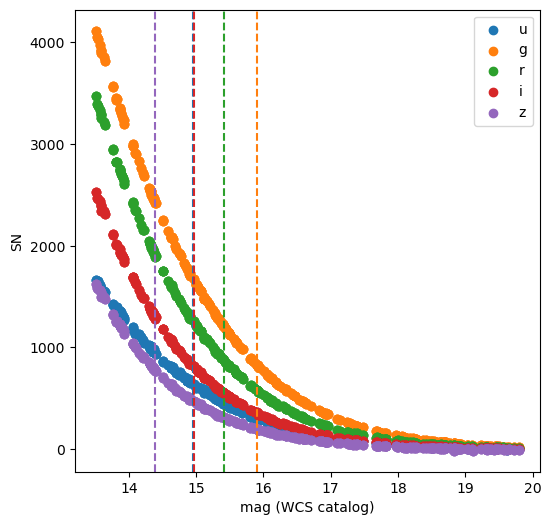

In [4]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['SN'], label=band, color=cmap(i))

    magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag (WCS catalog)')
ax.set_ylabel('SN')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


(1.8303672125518051, 4.919975113778284)

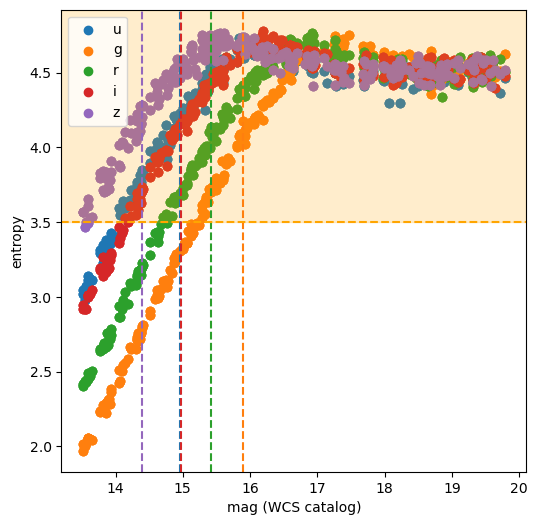

In [7]:
# entropy vs mag 
fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['entropy'],label=band)

    magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    ax.axvline(magMax, ls='--', c=cmap(i))
    i +=1 

ax.set_xlabel('mag (WCS catalog)')
ax.set_ylabel('entropy')
ax.legend()
xlims = ax.get_xlim()
ylims = ax.get_ylim()

#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')

ax.axhline(3.5, ls='--', c='orange')
ax.axhspan(3.5,  ylims[1], alpha=0.2, color='orange')
ax.set_xlim(xlims)
ax.set_ylim(ylims)


This shows that the default entropy threshold (3.5) doesn't really corresponds well to any of the filters. 

Plot the individual components to find out what varies as a function of magnitude:
* Signal vs Noise
* Signal vs Magnitude
* Noise vs Magnitude 

Note that here:
* 'Signal' is the `np.sum(image[donut_mask])` i.e. sum of pixel values inside the donut mask,
* 'Noise' is the `np.sqrt(variance[donut_mask].sum())`, i.e. the square root of the total variance of inside of the donut mask 

Text(0, 0.5, 'Signal: $\\sum \\mathrm{image[donut]}$')

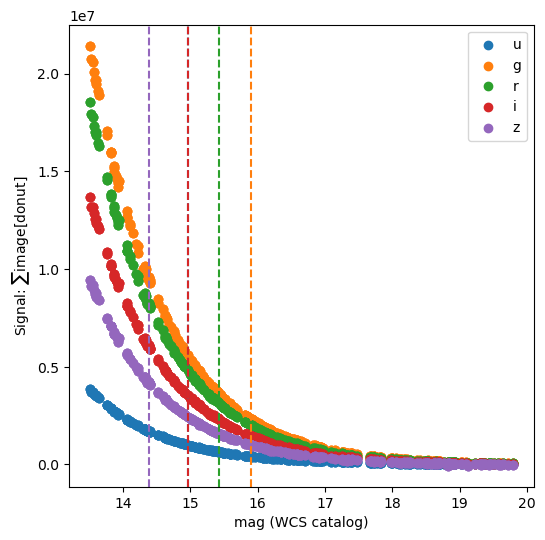

In [21]:


from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['signal_sum'], label=band, color=cmap(i))

    magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag (WCS catalog)')
ax.set_ylabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


Text(0, 0.5, 'Noise: $\\sqrt{\\sum \\mathrm{variance[donut]}}$')

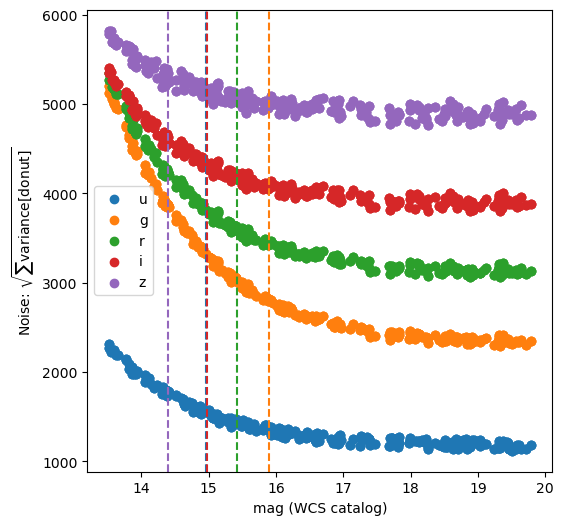

In [22]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['ttl_noise_donut_variance'], label=band, color=cmap(i))

    magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag (WCS catalog)')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


Text(0.5, 1.0, 'WCS-based')

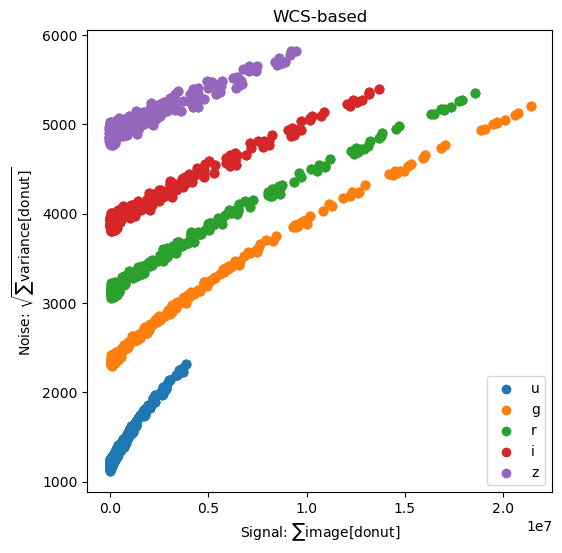

In [23]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter( summary[band]['signal_sum'],summary[band]['ttl_noise_donut_variance'],  label=band, color=cmap(i))

    magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()

ax.set_xlabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
ax.set_title('WCS-based')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')





Do the donuts look any different between bands?  

In [15]:
data = {}
for  band in 'ugriz':
    data[band] = np.load(f'wfs_grid5_ugriz_exposure_donuts_catalogs{band}.npy', allow_pickle=True).item()
    

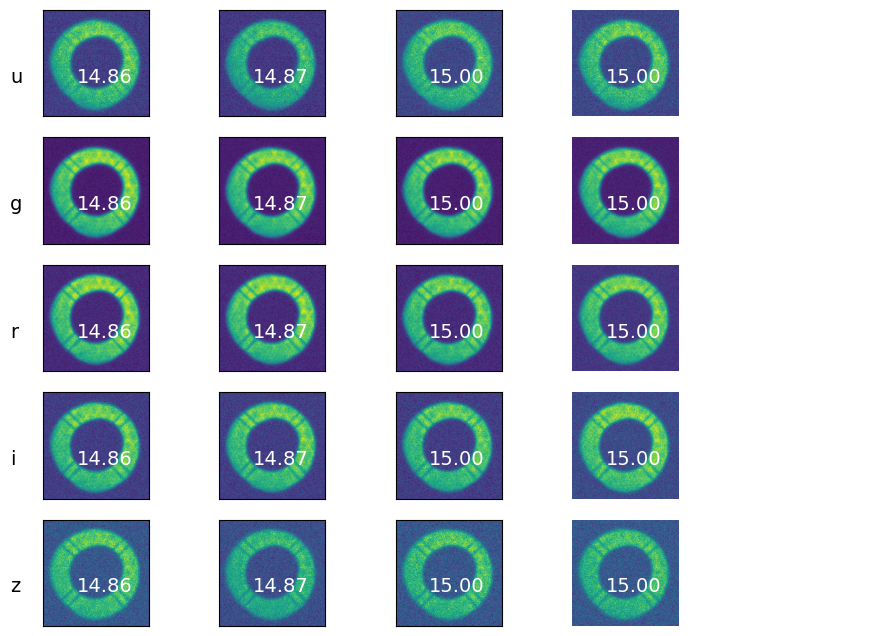

In [16]:
ncols=5
nrows=5
fig,axs = plt.subplots(nrows,ncols, figsize=(11,8))

row = 0
for row, band in enumerate('ugriz'):
    mag = data[band][191]['donutCatalogExtra']['mag']
    fullstamps = np.ravel(data[band][191]['donutStampsExtra'])

    selection = abs(mag-15)<0.2
    mask = selection.values
    if np.sum(mask) > 0:
        donuts = fullstamps[selection]
        
        ndonuts = len(donuts)
        axs[row,0].text(-50,50, band, fontsize=14)
        for i in range(ndonuts): #len(donutStampsExtra)):
            axs[row,i].imshow(donuts[i].stamp_im.image.array, origin='lower')
            axs[row,i].text(50,50, f'{mag[selection].values[i]:.2f}',
                            c='white', fontsize=14)
            axs[row,i].set_xticks([])
            axs[row,i].set_yticks([])
       
        if ndonuts < ncols:
            for j in range(i,ncols):
                axs[row,j].axis('off')

# Plots: Direct-detect 

In [1]:
import numpy as np 
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml



Plot SN vs magnitude. We're using the magnitude based on `source_flux` from WCS-based task, i.e. the same as the input sky catalog:

Text(0, 0.5, 'SN')

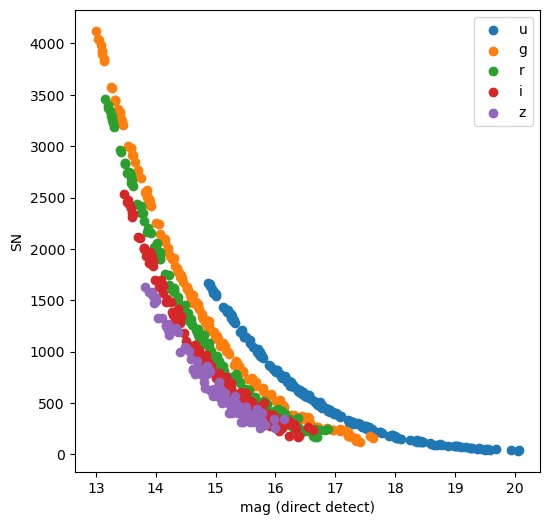

In [4]:

summary = np.load('wfs_grid5_ugriz_dets_summary_dic_direct.npy',allow_pickle=True).item()
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['SN'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag (direct detect)')
ax.set_ylabel('SN')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


The constituent elements:
* signal vs mag 
* noise vs mag
* signal vs noise (different) 


Text(0, 0.5, 'Signal: $\\sum \\mathrm{image[donut]}$')

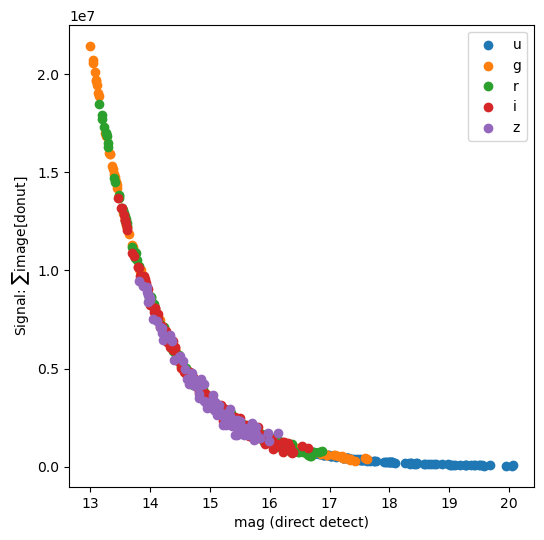

In [20]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['signal_sum'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag (direct detect)')
ax.set_ylabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')




Text(0, 0.5, 'Noise: $\\sqrt{\\sum \\mathrm{variance[donut]}}$')

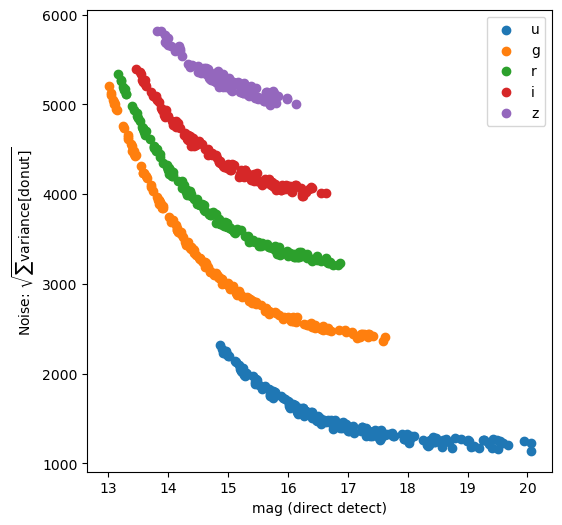

In [18]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['mag'], summary[band]['ttl_noise_donut_variance'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_xlabel('mag (direct detect)')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')




Text(0, 0.5, 'Noise: $\\sqrt{\\sum \\mathrm{variance[donut]}}$')

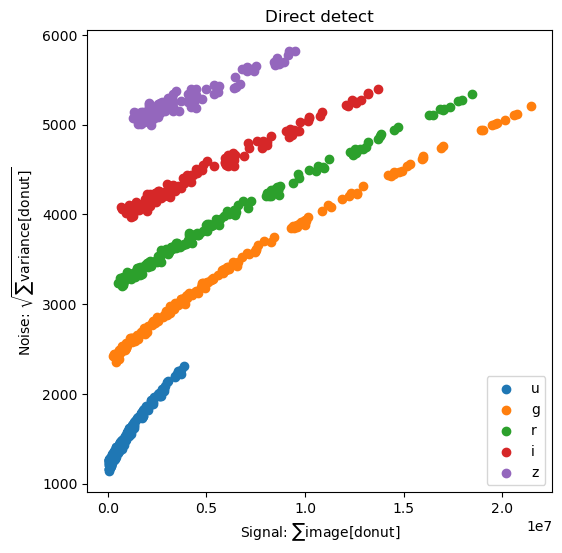

In [34]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in summary.keys() :
    ax.scatter(summary[band]['signal_sum'], summary[band]['ttl_noise_donut_variance'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()
ax.set_title('Direct detect')
ax.set_xlabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')




### Compare direct detect vs WCS-based:
* SN vs mag
* signal vs mag
* noise vs mag
* signal vs noise (should be identical)  

In [5]:
summary_wcs= np.load('wfs_grid5_ugriz_summary_dic.npy', allow_pickle=True).item()
summary_direct = np.load('wfs_grid5_ugriz_dets_summary_dic_direct.npy',allow_pickle=True).item()

Text(0, 0.5, 'SN')

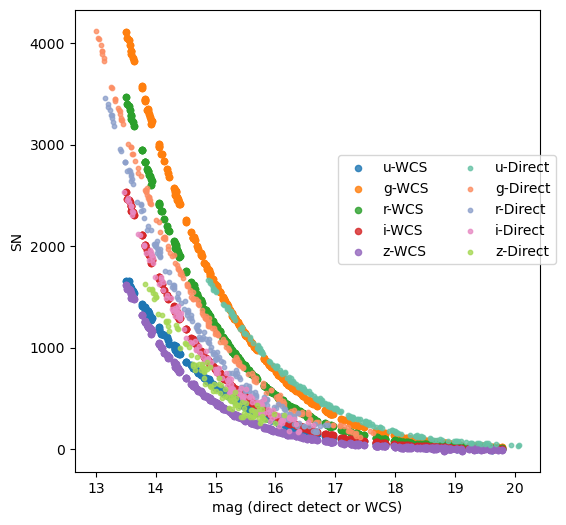

In [6]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap1 = cmaps['tab10']
cmap2 = cmaps['Set2']

fig,ax = plt.subplots(1,1,figsize=(6,6))

alpha=0.8
for summary, label, cmap, s in zip([summary_wcs, summary_direct],
                                 ['WCS', 'Direct'],
                                 [cmap1, cmap2],
                                   [20,10]
                                ):
    i = 0 
    for band in summary.keys() :
        ax.scatter(summary[band]['mag'], summary[band]['SN'], color=cmap(i),
                  label=f'{band}-{label}', 
                   alpha=alpha,
                  s=s)
    
        #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
        #ax.axvline(magMax, ls='--', c=cmap(i))
        i += 1 
ax.legend(bbox_to_anchor=[1.05,0.7], ncol=2)
xlims = ax.get_xlim()
ax.set_xlabel('mag (direct detect or WCS)')
ax.set_ylabel('SN')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


Isolate individual bands; make 5 sub-plots, one per band; otherwise too much data that's very similar; also plot the mag limits that we're comparing to: 

In [7]:
#summary

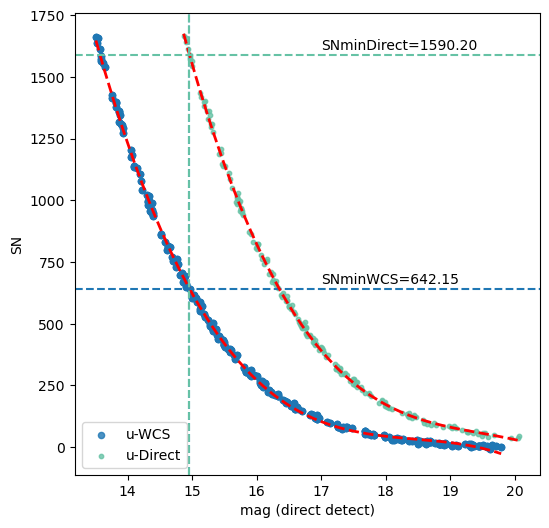

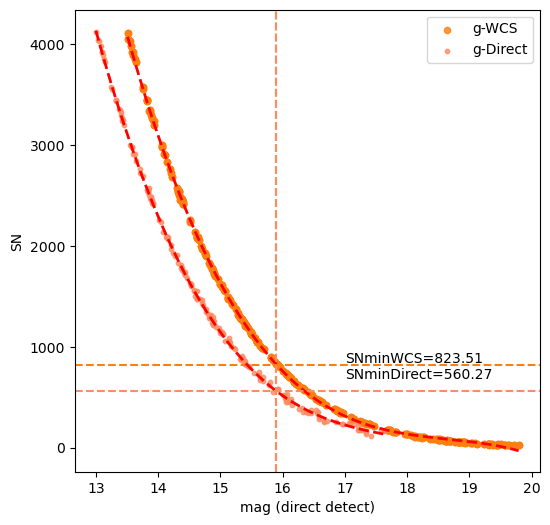

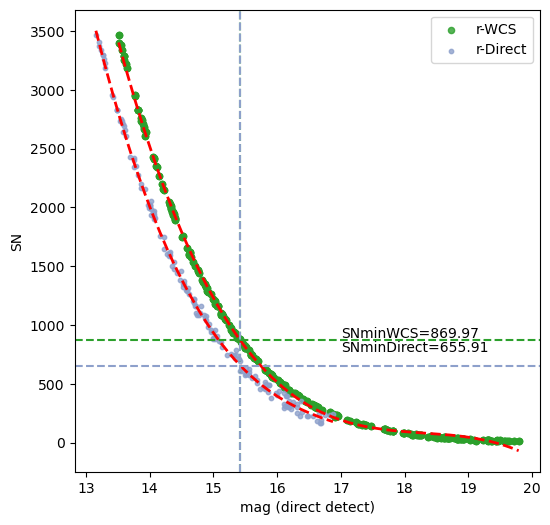

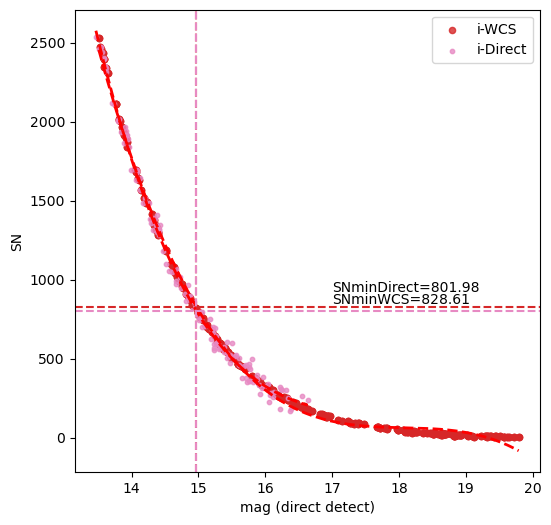

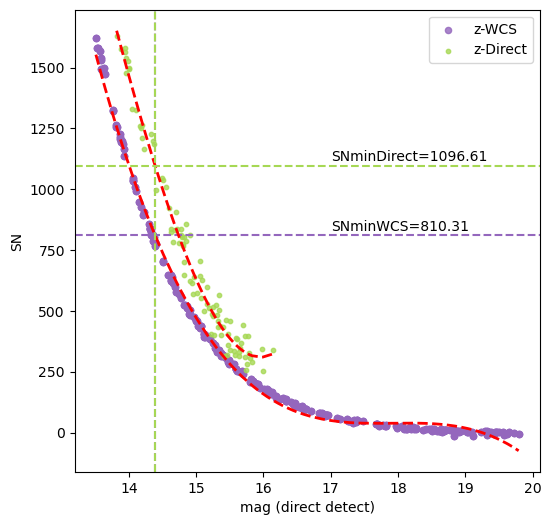

In [9]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
magPolicyDefaults = readConfigYaml("policy:magLimitStar.yaml")

#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap1 = cmaps['tab10']
cmap2 = cmaps['Set2']

snmin_dic = {}

alpha=0.8
i = 0 
for band in summary.keys():
    snmin_dic[band] = {}
    fig,ax = plt.subplots(1,1,figsize=(6,6))
    snMin0  = 0 
    for summary, label, cmap, s in zip([summary_wcs, summary_direct],
                                 ['WCS', 'Direct'],
                                 [cmap1, cmap2],
                                   [20,10]
                                ):
    
    #for band in summary.keys() :
        x = summary[band]['mag']
        y = summary[band]['SN']
        ax.scatter(x,y,  color=cmap(i),
                  label=f'{band}-{label}', 
                   alpha=alpha,
                  s=s)

        # fit a second order polynomial and overplot to find the intersection point 
        z = np.polyfit(x, y, 3)
        poly = np.poly1d(z)
        sorted_x = np.sort(x)
        ax.plot(sorted_x,poly(sorted_x), ls='--', c='r', lw=2)

       
   
        # plot the magnitude limit
        magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
        ax.axvline(magMax, ls='--', c=cmap(i))

        # given that we have a functional form of this dependency, we can find the intersection point
        # by evaluating the polynomial at the magnitude limit point
        snMin = poly(magMax)
        snmin_dic[band][label] = snMin
        ax.axhline(snMin, ls='--', c=cmap(i))
        yTextPos = snMin+20
        if (snMin - snMin0) < 80:
            yTextPos += 100
        ax.text(17,  yTextPos,s=f'SNmin{label}={snMin:.2f}')
        snMin0 = snMin
    i += 1 
    ax.legend()#bbox_to_anchor=[1.05,0.7], ncol=2)
    xlims = ax.get_xlim()
    ax.set_xlabel('mag (direct detect)')
    ax.set_ylabel('SN')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


Turn these to a `policy/yaml` file 

In [10]:
snmin_dic

{'u': {'WCS': 642.149606732637, 'Direct': 1590.2037974846608},
 'g': {'WCS': 823.5111087971891, 'Direct': 560.2717930081708},
 'r': {'WCS': 869.9660433410318, 'Direct': 655.9128472639422},
 'i': {'WCS': 828.6056306104292, 'Direct': 801.981807742035},
 'z': {'WCS': 810.309872267113, 'Direct': 1096.6129180489079}}

Take the smaller of each value:

In [13]:
snmin_dic[band]['WCS']

642.149606732637

In [14]:
for band in snmin_dic.keys():
    snmin_mean  = np.mean([snmin_dic[band]['WCS'],   snmin_dic[band]['Direct']])
    print(snmin_mean, band) 

1116.176702108649 u
691.8914509026799 g
762.939445302487 r
815.2937191762321 i
953.4613951580104 z


Text(0, 0.5, 'Signal: $\\sum \\mathrm{image[donut]}$')

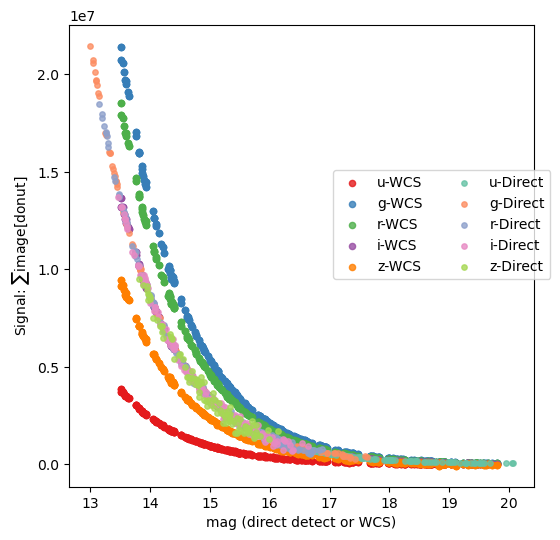

In [28]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap1 = cmaps['Set1']
cmap2 = cmaps['Set2']

fig,ax = plt.subplots(1,1,figsize=(6,6))

alpha=0.8
for summary, label, cmap, s in zip([summary_wcs, summary_direct],
                                 ['WCS', 'Direct'],
                                 [cmap1, cmap2],
                                   [20,15]
                                ):
    i = 0 
    for band in summary.keys() :
        ax.scatter(summary[band]['mag'], summary[band]['signal_sum'], color=cmap(i),
                  label=f'{band}-{label}', 
                   alpha=alpha,
                  s=s)
    
        #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
        #ax.axvline(magMax, ls='--', c=cmap(i))
        i += 1 
ax.legend(bbox_to_anchor=[1.05,0.7], ncol=2)
xlims = ax.get_xlim()
ax.set_xlabel('mag (direct detect or WCS)')
ax.set_ylabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


Text(0, 0.5, 'Noise: $\\sqrt{\\sum \\mathrm{variance[donut]}}$')

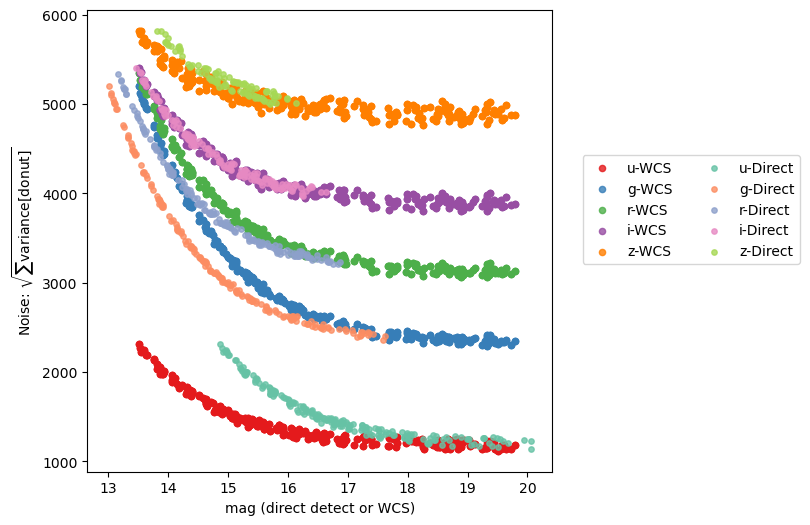

In [29]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap1 = cmaps['Set1']
cmap2 = cmaps['Set2']

fig,ax = plt.subplots(1,1,figsize=(6,6))

alpha=0.8
for summary, label, cmap, s in zip([summary_wcs, summary_direct],
                                 ['WCS', 'Direct'],
                                 [cmap1, cmap2],
                                   [20,15]
                                ):
    i = 0 
    for band in summary.keys() :
        ax.scatter(summary[band]['mag'], summary[band]['ttl_noise_donut_variance'], color=cmap(i),
                  label=f'{band}-{label}', 
                   alpha=alpha,
                  s=s)
    
        #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
        #ax.axvline(magMax, ls='--', c=cmap(i))
        i += 1 
ax.legend(bbox_to_anchor=[1.05,0.7], ncol=2)
xlims = ax.get_xlim()
ax.set_xlabel('mag (direct detect or WCS)')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


The signal vs noise for direct detect is the same as for WCS-based, because the underlying exposure information (image and variance plane) is the same (even if different donuts may have been selected). We overplot both below:

Text(0, 0.5, 'Noise: $\\sqrt{\\sum \\mathrm{variance[donut]}}$')

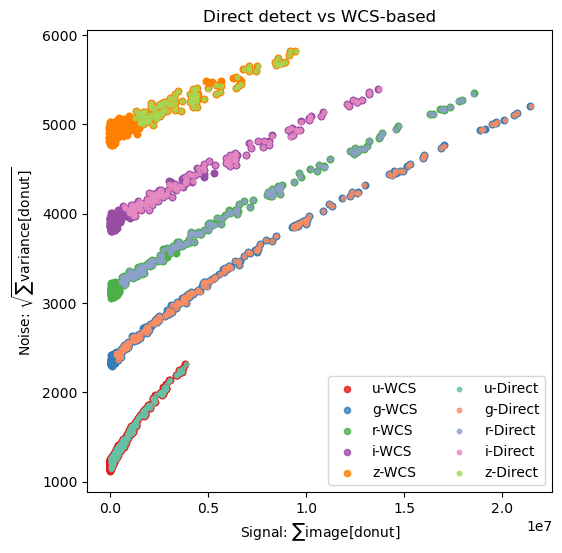

In [30]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

#cmap1 = cmaps['tab10']
cmap1 = cmaps['Set1']
cmap2 = cmaps['Set2']
alpha=0.8
fig,ax = plt.subplots(1,1,figsize=(6,6))
for summary, label, cmap, s in zip([summary_wcs, summary_direct],
                                 ['WCS', 'Direct'],
                                 [cmap1, cmap2],
                                   [20,10]
                                ):
    i = 0 
    for band in summary.keys() :
        ax.scatter(summary[band]['signal_sum'], 
                   summary[band]['ttl_noise_donut_variance'], 
                   label=f'{band}-{label}', 
                   color=cmap(i),
                   alpha=alpha,
                  s=s)
    
        #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
        #ax.axvline(magMax, ls='--', c=cmap(i))
        i += 1 
ax.legend(ncols=2)
xlims = ax.get_xlim()
ax.set_title('Direct detect vs WCS-based')
ax.set_xlabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')




So the Signal vs Noise plots for WCS-based and Direct detect-based are the same, since we're using the same donuts. The difference comes in when we start adding magnitude, since the WCS-based magnitudes are different than Direct-detect magnitudes.  We compare these below:

First , collect all info per band - detector  combination;  make one large astropy table per band 



In [122]:
direct_collection = 'ts_imsim_1000_direct' 
isr_wcs_collection = 'ts_imsim_1000'


summary_tab = {}
#summary_tab_direct = {}

for band in 'ugriz':

    summary_tab[band] = {}
    # read results via butler 
    butlerRootPath = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}/imsimData'
    butler = dafButler.Butler(butlerRootPath)
    for method, collection  in zip(['wcs', 'direct'],
                                       ['ts_imsim_1000','ts_imsim_1000_direct']):
        summary_tab[band][method] = {}
        
        for detExtra in [191, 195, 199, 203 ]:
            print(band, method, detExtra)
            dataIdExtra = {'instrument': 'LSSTCam', 'detector': detExtra, 'exposure': 7023062001000, 'visit':7023062001000}
            dataIdIntra = {'instrument': 'LSSTCam', 'detector': detExtra+1, 'exposure': 7023062001000, 'visit':7023062001000}

            #exposure_extra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[isr_wcs_collection])
            donutCatalogExtra = butler.get('donutCatalog', dataId=dataIdExtra, collections=[collection])
            donutCatalogIntra = butler.get('donutCatalog', dataId=dataIdIntra, collections=[collection])
            #donCatDet = butler.get('donutCatalog', dataId=dataIdExtra, collections=[direct_collection])

            # the signal/noise ratio, 
            # as well as individual signal, noise, entropy 
            # are all stored as donutStamps metadata 
            donutStampsExtraWcs = butler.get('donutStampsExtra',  dataId=dataIdExtra, collections=[collection])
            donutStampsIntraWcs = butler.get('donutStampsIntra',  dataId=dataIdExtra, collections=[collection])

            # get all the additional donut metadata added to the catalog 
            for key in list(donutStampsExtraWcs.metadata):
                metaListExtra = donutStampsExtraWcs.metadata.getArray(key)
                if len(metaListExtra) == len(donutCatalogExtra):
                    donutCatalogExtra[key] = metaListExtra
                
                metaListIntra = donutStampsIntraWcs.metadata.getArray(key)
                if len(metaListIntra) == len(donutCatalogIntra):
                    donutCatalogIntra[key] = metaListIntra
                    
            summary_tab[band][method][detExtra] = donutCatalogExtra
            summary_tab[band][method][detExtra+1] = donutCatalogIntra
         

u wcs 191
u wcs 195
u wcs 199
u wcs 203
u direct 191
u direct 195
u direct 199
u direct 203
g wcs 191
g wcs 195
g wcs 199
g wcs 203
g direct 191
g direct 195
g direct 199
g direct 203
r wcs 191
r wcs 195
r wcs 199
r wcs 203
r direct 191
r direct 195
r direct 199
r direct 203
i wcs 191
i wcs 195
i wcs 199
i wcs 203
i direct 191
i direct 195
i direct 199
i direct 203
z wcs 191
z wcs 195
z wcs 199
z wcs 203
z direct 191
z direct 195
z direct 199
z direct 203


Collate the individual "extended" donut catalogs so that we have just one long list per band:

In [124]:
extended_cat = {}

for band in 'ugriz':
    extended_cat[band]={}
    for method in ['wcs', 'direct']:
        detExtra = 191
        a = Table.from_pandas(summary_tab[band][method][detExtra])
        b = Table.from_pandas(summary_tab[band][method][detExtra+1])
        # these have identical columns so can be simply stack on top of each other 
        c = vstack([a,b])
        
        for detExtra in [ 195, 199, 203 ]:
            a = Table.from_pandas(summary_tab[band][method][detExtra])
            b = Table.from_pandas(summary_tab[band][method][detExtra+1])
            print(len(a), len(b), len(a)+len(b))
            c = vstack([c,a,b])
        # this is a combined catalog that 
        # contains information about all donuts
        # in all detectors, both intra and extra 
        extended_cat[band][method] = c


66 63 129
66 63 129
66 63 129
41 36 77
47 33 80
45 36 81
66 63 129
66 63 129
66 63 129
40 30 70
46 23 69
45 24 69
66 63 129
66 63 129
66 63 129
38 20 58
41 18 59
44 19 63
66 63 129
66 63 129
66 63 129
31 18 49
34 13 47
35 15 50
66 63 129
66 63 129
66 63 129
22 8 30
28 6 34
23 8 31


In [125]:
np.unique(extended_cat[band][method]['DET_NAME'].value)

array(['R00_SW0', 'R00_SW1', 'R04_SW0', 'R04_SW1', 'R40_SW0', 'R40_SW1',
       'R44_SW0', 'R44_SW1'], dtype='<U7')

In [126]:
extended_cat[band][method].colnames

['coord_ra',
 'coord_dec',
 'centroid_x',
 'centroid_y',
 'detector',
 'source_flux',
 'blend_centroid_x',
 'blend_centroid_y',
 'RA_DEG',
 'DEC_DEG',
 'DET_NAME',
 'CAM_NAME',
 'DFC_TYPE',
 'DFC_DIST',
 'MAG',
 'CENT_X0',
 'CENT_Y0',
 'CENT_X',
 'CENT_Y',
 'CENT_DR',
 'BLEND_CX',
 'BLEND_CY',
 'X0',
 'Y0',
 'SN',
 'SIGNAL_MEAN',
 'SIGNAL_SUM',
 'NPX_MASK',
 'BKGD_STDEV',
 'SQRT_MEAN_VAR',
 'BKGD_VAR',
 'BACKGROUND_IMAGE_MEAN',
 'NOISE_VAR_BKGD',
 'NOISE_VAR_DONUT',
 'EFFECTIVE',
 'ENTROPY',
 'PEAK_HEIGHT',
 'BANDPASS',
 'ARCHIVE_IDS']

And indeed all detectors are present! So now it should be possible to recreate the plots comparing different bands: 

Text(0, 0.5, 'Noise: $\\sqrt{\\sum \\mathrm{variance[donut]}}$')

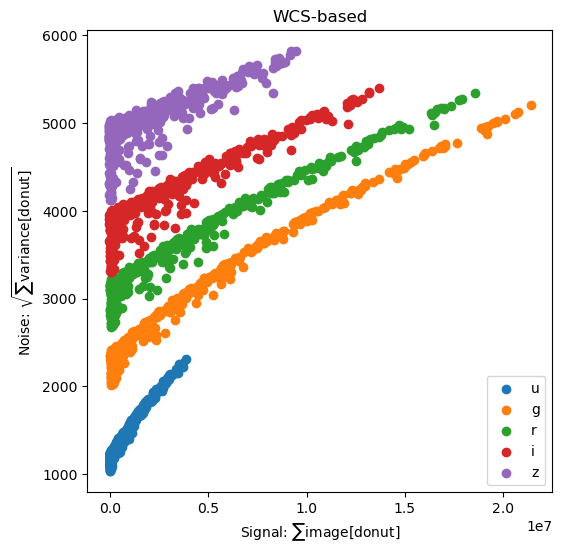

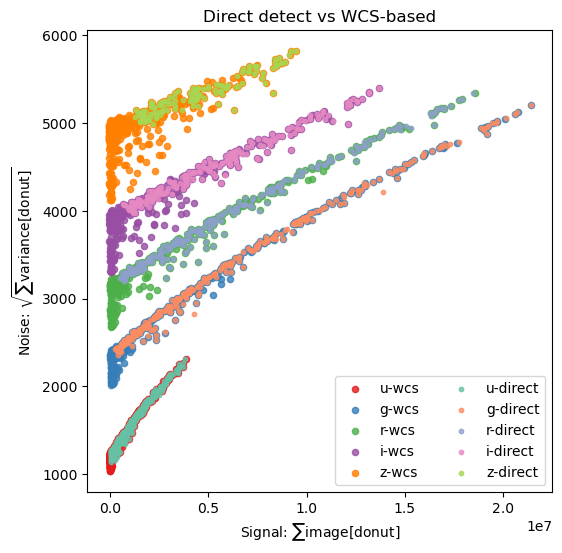

In [129]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in 'ugriz':
    ax.scatter( extended_cat[band]['wcs']['SIGNAL_SUM'], extended_cat[band]['wcs']['NOISE_VAR_DONUT'],  label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 
ax.legend()
xlims = ax.get_xlim()

ax.set_xlabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
ax.set_title('WCS-based')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')


from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

#cmap1 = cmaps['tab10']
cmap1 = cmaps['Set1']
cmap2 = cmaps['Set2']
alpha=0.8
fig,ax = plt.subplots(1,1,figsize=(6,6))
for method, cmap, s in zip(      ['wcs', 'direct'],
                                 [cmap1, cmap2],
                                   [20,10]
                                ):
    i = 0 
    for band in  'ugriz':
        ax.scatter(extended_cat[band][method]['SIGNAL_SUM'], 
                   extended_cat[band][method]['NOISE_VAR_DONUT'], 
                   label=f'{band}-{method}', 
                   color=cmap(i),
                   alpha=alpha,
                  s=s)
    
        #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
        #ax.axvline(magMax, ls='--', c=cmap(i))
        i += 1 
ax.legend(ncols=2)
xlims = ax.get_xlim()
ax.set_title('Direct detect vs WCS-based')
ax.set_xlabel('Signal: '+r'$\sum \mathrm{image[donut]}$')
ax.set_ylabel('Noise: '+r'$\sqrt{\sum \mathrm{variance[donut]}}$')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')






I have no idea why the above would look so different from  the in-notebook result ... Perhaps in a new notebook include only the butler-repo based plots? 

In [74]:
c = SkyCoord(ra=donCatDet['coord_ra'].values*u.degree, 
                   dec=donCatDet['coord_dec'].values*u.degree)
catalog = SkyCoord(ra=donCatWcs['coord_ra'].values*u.degree, 
             dec=donCatWcs['coord_dec'].values*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

donCatDetTable = Table.from_pandas(donCatDet)
donCatWcsTable = Table.from_pandas(donCatWcs)

donCatMerge = hstack([donCatDetTable, donCatWcsTable[idx]], table_names=['det','wcs'])


{'SIMPLE': [True],
 'BITPIX': [8],
 'NAXIS': [0],
 'EXTEND': [True],
 'COMMENT': ["  FITS (Flexible Image Transport System) format is defined in 'Astronomy",
  "  and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H"],
 'RA_DEG': [358.452225942125,
  358.365068996316,
  358.407233567884,
  358.462978724456,
  358.320076622075,
  358.45024469721,
  358.328848159492,
  358.428739132547,
  358.332810649321,
  358.339600941824,
  358.412042615472,
  358.294608567583,
  358.35233496907,
  358.388555805894,
  358.367050241231,
  358.305361349914,
  358.414023860386,
  358.441473159793,
  358.373840533733,
  358.396480785552,
  358.356297458899,
  358.341582186738,
  358.409214812798,
  358.417986350215,
  358.377803023562,
  358.354316213984,
  358.281874540336,
  358.345544676567,
  358.437510669964,
  358.416005105301,
  358.41996759513,
  358.405252322969,
  358.40128983314,
  358.337619696909,
  358.439491914879,
  358.316114132246,
  358.361106506487,
  358.426757887632

In [68]:
donutsExtraQualityWcs = butler.get('donutsExtraQuality', dataId=dataIdExtra, collections=[isr_wcs_collection])

{'instrument': 'LSSTCam',
 'detector': 191,
 'exposure': 7023062001000,
 'visit': 7023062001000}

In [67]:

donutsIntraQualityWcs  = butler.get('donutsIntraQuality', dataId=dataIdIntra, collections=[isr_wcs_collection])
donutsExtraQualityDirect = butler.get('donutsExtraQuality', dataId=dataIdExtra,  collections=[direct_collection])
donutsIntraQualityDirect = butler.get('donutsIntraQuality', dataId=dataIdIntra,  collections=[direct_collection])

DatasetNotFoundError: Dataset donutsExtraQuality with data ID {instrument: 'LSSTCam', detector: 191, visit: 7023062001000} could not be found in collections ['ts_imsim_1000'].

# Compare WCS-based (catalog) fluxes vs Direct-detection (measured) fluxes 

Below we cross match the WCS-based donut catalogs and the Direct-detection catalogs:

In [60]:
# import numpy as np 
# results_direct = {}
# band = 'u'
# results_direct[band] = np.load(f'results_directDetect_alldets_{band}.npy', allow_pickle=True).item()

In [61]:
# results_wcs = {}
# #for  band in 'ugriz':
# results_wcs[band] = np.load(f'wfs_grid5_ugriz_exposure_donuts_catalogs{band}.npy', allow_pickle=True).item()
    

Illustrate the process with one exposure in the g-band:

In [63]:
# results_direct[band].keys()

In [62]:
# results_wcs[band].keys()

In [12]:

import lsst.daf.butler as dafButler

band = 'u'
detExtra = 191 
# donCatDet = results_direct[band][detExtra]['donutCatalogExtra']
# donCatWcs = results_wcs[band][detExtra]['donutCatalogExtra']
# exposure_extra = results_wcs[band][detExtra]['exposure_extra']

# read results via butler 
butlerRootPath = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}/imsimData'

direct_collection = 'ts_imsim_1000_direct' 
isr_wcs_collection = 'ts_imsim_1000'

butler = dafButler.Butler(butlerRootPath)
#for detExtra in  [191, 195, 199, 203 ]:

dataIdExtra = {'instrument': 'LSSTCam', 'detector': detExtra, 'exposure': 7023062001000, 'visit':7023062001000}
dataIdIntra = {'instrument': 'LSSTCam', 'detector': detExtra+1, 'exposure': 7023062001000, 'visit':7023062001000}

exposure_extra = butler.get('postISRCCD', dataId=dataIdExtra, collections=[isr_wcs_collection])
donCatWcs = butler.get('donutCatalog', dataId=dataIdExtra, collections=[isr_wcs_collection])
donCatDet = butler.get('donutCatalog', dataId=dataIdExtra, collections=[direct_collection])


In [14]:
from astropy.visualization import ZScaleInterval
zscale = ZScaleInterval()

In [21]:
cmap(10)


(0.09019607843137255, 0.7450980392156863, 0.8117647058823529, 1.0)

Text(0.5, 1.0, 'R00_SW0 (u) ')

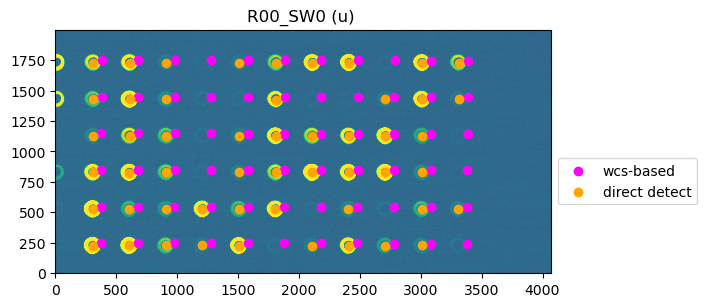

In [36]:
import matplotlib.pyplot as plt
from matplotlib import colormaps as cmaps
d = exposure_extra.image.array
vmin,vmax=  zscale.get_limits(d)
plt.imshow(d, vmin=vmin,vmax=vmax, origin='lower')
cmap = cmaps['tab10']
plt.scatter(donCatWcs['centroid_x'], donCatWcs['centroid_y'], label='wcs-based', color='magenta')
plt.scatter(donCatDet['centroid_x'], donCatDet['centroid_y'], label='direct detect',color='orange')
plt.legend(bbox_to_anchor=[1,0.5])
plt.title(exposure_extra.detector.getName()+f' ({exposure_extra.filter.bandLabel}) ')

Text(0, 0.5, 'DEC [deg]')

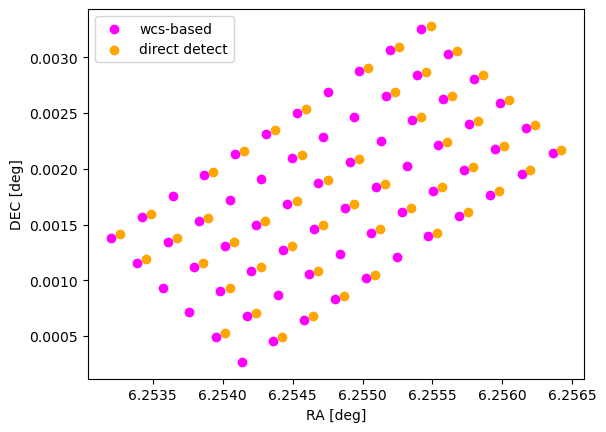

In [38]:
#plt.imshow(exposure_extra.image.array, origin='lower')
plt.scatter(donCatWcs['coord_ra'], donCatWcs['coord_dec'], label='wcs-based', color='magenta')
plt.scatter(donCatDet['coord_ra'], donCatDet['coord_dec'], label='direct detect', color='orange')
plt.legend()
plt.xlabel('RA [deg]')
plt.ylabel('DEC [deg]')

Compare now only those donuts that are both in direct-detect and wcs-based.  Try cross-matching the two catalogs:

Instead of using the numpy pickles (which crashes due to insufficient memory) try reading via butler only the necessary data products: 

In [40]:
from astropy.coordinates import SkyCoord 
import astropy.units as u
from astropy.table import join, hstack, vstack
from astropy.table import Table
c = SkyCoord(ra=donCatDet['coord_ra'].values*u.degree, 
                   dec=donCatDet['coord_dec'].values*u.degree)
catalog = SkyCoord(ra=donCatWcs['coord_ra'].values*u.degree, 
             dec=donCatWcs['coord_dec'].values*u.degree)
idx, d2d, d3d = c.match_to_catalog_sky(catalog)

donCatDetTable = Table.from_pandas(donCatDet)
donCatWcsTable = Table.from_pandas(donCatWcs)

donCatMerge = hstack([donCatDetTable, donCatWcsTable[idx]], table_names=['det','wcs'])


In [41]:
len(donCatDet)

52

In [43]:
len(donCatWcs)


66

In [46]:
donCatMerge

coord_ra_det,coord_dec_det,centroid_x_det,centroid_y_det,detector,source_flux_det,blend_centroid_x_det,blend_centroid_y_det,coord_ra_wcs,coord_dec_wcs,centroid_x_wcs,centroid_y_wcs,source_flux_wcs,blend_centroid_x_wcs,blend_centroid_y_wcs
float64,float64,float64,float64,str7,float64,object,object,float64,float64,float64,float64,float64,object,object
6.256235105136615,0.002394486145473475,307.89275037556195,527.5648034968816,R00_SW0,4093079.775362015,[],[],6.2561715537927105,0.0023658027722674247,377.22185783323584,547.1948868060972,14319444.670216061,[],[]
6.254715542263219,0.0014937105785470662,2108.6005490249277,827.2209084078946,R00_SW0,3756543.49269104,[],[],6.254650378122364,0.0014620247421325032,2181.221926166294,845.5609009321051,13339836.014520856,[],[]
6.25642224730518,0.002172295480180653,307.39330534503426,227.49471559808927,R00_SW0,3262400.353038788,[],[],6.256359225248147,0.002143552069782494,376.34225579784106,246.72323170820164,11337553.140845373,[],[]
6.255451232602302,0.002873348612240283,610.081646881536,1427.5980812511048,R00_SW0,3213069.7700691223,[],[],6.2553862887239156,0.0028448834242855736,680.3749288378531,1448.3344829136367,11339598.889004385,[],[]
6.253931577091538,0.001972394359081808,2411.1639457121905,1727.33126913384,R00_SW0,2879425.150045395,[],[],6.253865113053569,0.0019411053941506549,2484.5585753211853,1746.8577397561567,10366285.3485584,[],[]
6.256200298934696,0.0019854292572340513,607.0933161028715,227.55728158446433,R00_SW0,2481705.4563827515,[],[],6.2561369745456625,0.001955880614345851,676.819466374971,246.3518932089828,8656634.542610819,[],[]
6.255826489030593,0.00242875330241575,608.4313906948239,826.5686662453398,R00_SW0,2360316.9529571533,[],[],6.255761631634789,0.0024003820193157104,678.5911727227394,847.3175936909392,8270725.715302597,[],[]
6.25408422449175,0.0013412455291760977,2709.570976356718,1127.002031455531,R00_SW0,2329103.4548130035,[],[],6.254018205261958,0.0013089325337441557,2783.2945917418474,1145.4200977095315,8349244.783830344,[],[]
6.254153965705862,0.0021594486624675726,2110.8865113956504,1727.0782047324876,R00_SW0,2055995.938495636,[],[],6.254087363756055,0.002128776849587296,2183.976636977917,1747.1829276972276,7401454.615639816,[],[]


In [54]:
from astropy.coordinates import SkyCoord 
import astropy.units as u
from astropy.table import join, hstack, vstack
from astropy.table import Table


direct_collection = 'ts_imsim_1000_direct' 
isr_wcs_collection = 'ts_imsim_1000'

merged_catalog = {}

# crossmatch donut catalog from direct detection to  WCS. Compare reported fluxes: 
for band in 'ugriz':
    merged_catalog[band] = {}
    butlerRootPath = f'/sdf/group/rubin/shared/scichris/DM-43524_grid/wfs_grid5{band}/imsimData'
    butler = dafButler.Butler(butlerRootPath)
    #for detExtra in results_direct[band].keys() :
    for detExtra in [191, 195, 199, 203 ]:

        donCatWcs = butler.get('donutCatalog', dataId=dataIdExtra, collections=[isr_wcs_collection])
        donCatDet = butler.get('donutCatalog', dataId=dataIdExtra, collections=[direct_collection])

        # convert fluxes to magnitudes
        donCatWcs['mag'] = (donCatWcs['source_flux'].values * u.nJy).to_value(u.ABmag)
        donCatDet['mag'] = (donCatDet['source_flux'].values * u.nJy).to_value(u.ABmag)
        
        #donCatDet = results_direct[band][detExtra]['donutCatalogExtra']
        #donCatWcs = results_wcs[band][detExtra]['donutCatalogExtra']
        
        # We crossmatch  direct detect -->   WCS , because we know 
        # that direct detect in this case is a subset of WCS-based one 
        c = SkyCoord(ra=donCatDet['coord_ra'].values*u.degree, 
                           dec=donCatDet['coord_dec'].values*u.degree)
        catalog = SkyCoord(ra=donCatWcs['coord_ra'].values*u.degree, 
                     dec=donCatWcs['coord_dec'].values*u.degree)
        idx, d2d, d3d = c.match_to_catalog_sky(catalog)
        
        donCatDetTable = Table.from_pandas(donCatDet)
        donCatWcsTable = Table.from_pandas(donCatWcs)
        
        donCatMerge = hstack([donCatDetTable, donCatWcsTable[idx]], table_names=['det','wcs'])
        
        #results_direct[band][detExtra]['donutCatalogExtraMerged'] = donCatMerge
        merged_catalog[band][detExtra] = donCatMerge
print('Done')

Done


In [55]:
fluxes = {}
for band in 'ugriz':
    fluxes[band] = {}
    fluxes[band]['mag_det'] = []
    fluxes[band]['mag_wcs'] = []
    fluxes[band]['source_flux_det'] = []
    fluxes[band]['source_flux_wcs'] = []
    
for band in 'ugriz':
    fluxes[band]['mag_det'].extend(
      merged_catalog[band][detExtra]['mag_det'].data)

    fluxes[band]['mag_wcs'].extend(
      merged_catalog[band][detExtra]['mag_wcs'].data)

    fluxes[band]['source_flux_det'].extend(
      merged_catalog[band][detExtra]['source_flux_det'].data)
    fluxes[band]['source_flux_wcs'].extend(
      merged_catalog[band][detExtra]['source_flux_wcs'].data)
    

Plot magnitudes: 

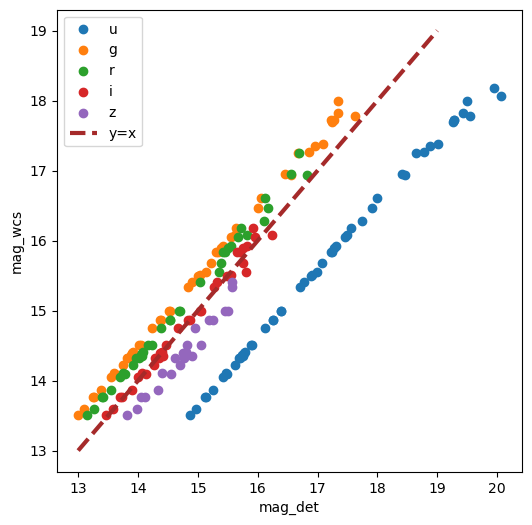

In [58]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in fluxes.keys() :
    ax.scatter(fluxes[band]['mag_det'], fluxes[band]['mag_wcs'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 

xlims = ax.get_xlim()
ax.set_xlabel('mag_det')
ax.set_ylabel('mag_wcs')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')
x = np.linspace(13,19)
ax.plot(x,x, c='brown',ls='--',lw=3, label='y=x')
ax.legend()

Plot fluxes: 

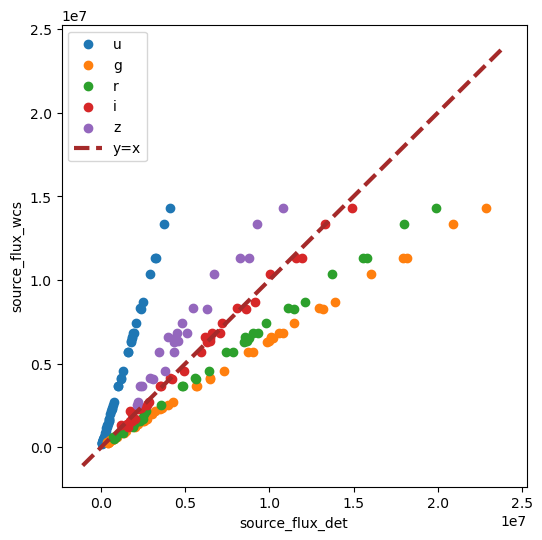

In [57]:
from matplotlib import colormaps as cmaps
import matplotlib.pyplot as plt 
from lsst.ts.wep.utils import readConfigYaml
#
#magMax = magPolicyDefaults[defaultFilterKey]["high"]

cmap = cmaps['tab10']

fig,ax = plt.subplots(1,1,figsize=(6,6))
i = 0 
for band in fluxes.keys() :
    ax.scatter(fluxes[band]['source_flux_det'], fluxes[band]['source_flux_wcs'], label=band, color=cmap(i))

    #magMax = magPolicyDefaults[f'filter{band.upper()}']["high"]
    #ax.axvline(magMax, ls='--', c=cmap(i))
    i += 1 

xlims = ax.get_xlim()
ax.set_xlabel('source_flux_det')
ax.set_ylabel('source_flux_wcs')
#ax.axvline(15.90, ls='--', c='r')
#ax.axvspan(15.9, xlims[1], alpha=0.2, color='red')
x = np.linspace(xlims[0], xlims[1])
ax.plot(x,x, c='brown',ls='--',lw=3, label='y=x')
ax.legend()

The `source_flux_det` comes from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/donutQuickMeasurementTask.py#L107   after subtracting the median from the image.  The `source_flux_wcs` comes from https://github.com/lsst-ts/ts_wep/blob/develop/python/lsst/ts/wep/task/generateDonutCatalogWcsTask.py 